<a href="https://colab.research.google.com/github/kshptl/AI-for-Trading/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from keras_OneCycle import OneCycle
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
#import tensorflow as tf
#from tensorflow import keras

#import tensorflow.keras.models as M
#import tensorflow.keras.layers as L
#from keras import backend as K
#keras.backend

#import tensorflow as tf
#from tensorflow import keras #<------- use this for tensorflow



import matplotlib.pyplot as plt
#!pip install mplfinance
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
#!pip install keras_lr_finder
from keras_lr_finder import LRFinder

Using plaidml.keras.backend backend.


In [2]:
cd data

/Users/kush/Desktop/DS/inpredo-master/RNN_tabular/AI-for-Trading/data


In [3]:
data = pd.read_csv("ND100.M5.csv", parse_dates=True,  names=["open", "high", "low", "close", "volume"])

# # change timeframe
logic = {'open'  : 'first',
         'high'  : 'max',
         'low'   : 'min',
         'close' : 'last',
         'volume': 'sum'}
offset = pd.offsets.timedelta(days=-6)
data = data.resample('1H', loffset=offset).apply(logic)

data.reset_index(drop=True, inplace=True)
data = data[["close", "volume", "open", "high", "low"]]
data['pandas_SMA_10'] = data.iloc[:,0].rolling(window=3).mean()
data = data.fillna(0)

In [4]:
data

,close,volume,open,high,low,pandas_SMA_10
0,7224.7,2065,7220.4,7226.6,7216.0,0.000000
1,7220.0,5689,7224.6,7236.5,7207.2,0.000000
2,7218.4,6811,7219.7,7253.9,7209.6,7221.033333
3,7186.5,6643,7218.7,7235.2,7175.5,7208.300000
4,7196.5,6166,7186.7,7211.0,7180.0,7200.466667
...,...,...,...,...,...,...
12577,11211.5,24955,11145.1,11212.7,11114.4,11165.266667
12578,11345.5,39718,11211.4,11347.5,11208.9,11234.066667
12579,11307.4,29929,11345.0,11359.1,11298.6,11288.133333
12580,11308.5,19572,11307.5,11338.9,11286.5,11320.466667


In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, predict_forward=3, column=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-predict_forward):
        j = i + look_back
        a = dataset[i:j,:]
        dataX.append(a)
		
        # for predicting actual price
        #dataY.append(dataset[j:j + predict_forward, column])

        # for % change
        #pct = (-data[i + look_back,3] + data[i + look_back+ predict_forward, 3])/data[i + look_back,3]
        #if data[i + look_back,3] == 0:
        #	print(i,"zero")

        # for direction
        if dataset[j,0] >= dataset[j-1,0]:
            dataY.append(1)
        else:
            dataY.append(0)

    return np.array(dataX), np.array(dataY)

In [6]:
# fix random seed for reproducibility
np.random.seed(42)
normalize_max = 1
# normalize the dataset
x_scaler = MinMaxScaler(feature_range=(0,normalize_max))
data = x_scaler.fit_transform(data)

# remove values that are 0
data = np.delete(data,np.where(data==0)[0],axis=0)

In [7]:
n_bars = 12
predict_forward = 1
x_train, y_train = create_dataset(data,n_bars, predict_forward=predict_forward, column=0)

#remove the last sample one bc it may not have enough  y_train values (if the dataset size doenst evenly divide into the sample size)
x_train = x_train[:-predict_forward]
y_train = np.stack(y_train[:-predict_forward])

In [8]:
# scale y_train
y_scaler = MinMaxScaler(feature_range=(0,1))
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))

In [9]:
y_train[0]

array([1.])

In [10]:
# define model
regularizer = keras.regularizers.l2()
def make_model(input_shape):

    model = keras.models.Sequential()
    #model.add(tf.compat.v1.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='selu'))
    #model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.GRU(100,input_shape=input_shape, recurrent_regularizer=None, return_sequences=True, recurrent_dropout=0.5, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.GRU(1000,input_shape=input_shape, recurrent_regularizer=None, return_sequences=True, recurrent_dropout=0.5, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.GRU(1000,input_shape=input_shape, recurrent_regularizer=None, return_sequences=True, recurrent_dropout=0.5, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.GRU(1000,input_shape=input_shape, recurrent_regularizer=None, recurrent_dropout=0.5, activation="relu"))
    model.add(keras.layers.Dense(1, activation="softmax"))
    
    return model

model = make_model(input_shape=x_train.shape[1:])
#model.build(input_shape=x_train.shape[:])

callbacks = [
    #OneCycle(min_lr=7e-6, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing_stage=0.1, annealing_rate=0.01, training_iterations=np.ceil(((x_train.shape[0]*epochs)/(batch_size)))),

    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="accuracy", patience=20, verbose=1),
]

opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

keras.utils.plot_model(model, show_shapes=True)
model.summary()

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
#model.save("my_model")

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("my_model")

INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 12, 100)           32100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 100)           400       
_________________________________________________________________
gru_2 (GRU)                  (None, 12, 1000)          3303000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 1000)          4000      
_________________________________________________________________
gru_3 (GRU)                  (None, 12, 1000)          6003000   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 1000)          4000      
_________________________________________________________________
gru_4 (GRU)      

In [36]:
# fit model : mse - 4e-4 : valmse - 6e-4 : (2x 10 neurons with dropout0.9, relu activation on both) - 0.5 dropout converges quicker
# increased n_bars to 20 and added 10-SMA and added another gru layer (total 3 x 20) -> mae is .10
# added another layer (total 4 x 20) -> val_mae is 0.030
#model = keras.models.load_model('model')
history = model.fit(x_train, y_train, epochs=500, verbose=1, batch_size=128, callbacks=callbacks, validation_split=0.2)
model.save('modelsave')

Train on 6166 samples, validate on 1542 samples
Epoch 1/500
INFO:plaidml:Analyzing Ops: 4161 of 4585 operations complete
6166/6166 [==============================] - 32s 5ms/step - loss: 7.3843 - acc: 0.5368 - val_loss: 7.1234 - val_acc: 0.5532
Epoch 2/500
6144/6166 [============================>.] - ETA: 0s - loss: 7.3900 - acc: 0.5365

In [26]:
# show traning/validation plots
metric = "mse"
plt.figure(figsize=(10,10))
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

NameError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
y_train[-i].shape

In [ ]:
# get latest prediction
i = 80
x_pred = x_train[-i]
prediction = model.predict(x_pred.reshape(1,10,5))
y_pred = y_scaler.inverse_transform(prediction)
y_actual = y_train[-i]
print("Prediction: ",y_pred[0][0])
print( "Actual: ", y_actual[0])
print("MSE: ", (y_actual[0]- y_pred[0][0])**2)

# plot latest prediction
#plt.plot(np.arange(1,y_pred.shape[1]+1),y_pred[0]);
#plt.plot(np.arange(y_pred.shape[1]+1,len(y_actual[0])+1),y_actual[0]);

Epoch 1/5
100268/100268 [==============================] - 17s 172us/step - loss: 5.0925 - mean_squared_error: 3.4010
Epoch 2/5
 43776/100268 [============>.................] - ETA: 9s - loss: 0.4790 - mean_squared_error: 0.2314

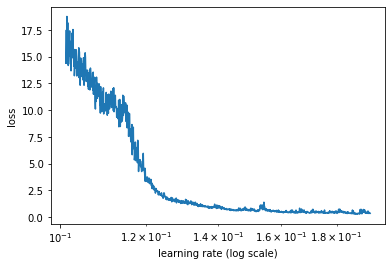

In [26]:
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 128 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 2
lr_finder.find(x_train, y_train, start_lr=1e-1, end_lr=1e-0, batch_size=128, epochs=5)

# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [ ]:
tmp